<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/lupis30puc-update-4/Yelp_10epochs_trainning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp dataset on kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset)

12,993 samples from the Yelp Dataset Challenge 2020. 
Divided on train, validation and test subsets. 

Their corresponding sizes are: 10,394 train samples, 1,949 validation samples and 650 test samples.


Tutorial on which I support: 
[BERT Fine-Tunning](http://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification)
[Colab: BERT for sequential classification](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=DEfSbAA4QHas)




> On this notebook I'll run the model 10 epochs with the dataset without short and stop words



In [22]:
!pip install transformers

# Set up

## GPU

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Loading the pre-processed dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import re

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_train_10394.pkl')
validation_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_validation_1949.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Yelp/sample_test_650.pkl')

In [ ]:
train_df.head()

,text,label,categories
11349,second best pool las vegas pay commit day drin...,1,"Arts & Entertainment, Casinos, Hotels, Hotels ..."
12582,went tuesday night jan weather nice course dec...,0,"Arts & Entertainment, Nightlife, Breakfast & B..."
4547,experience duplicates reviews purchased living...,0,"Home Services, Office Cleaning, Window Washing..."
11873,mmmmmmr sushi place lost sushi virginity place...,1,"Restaurants, Sushi Bars, Japanese"
12416,little strip provide monorail service lvh stri...,1,"Casinos, Nightlife, Restaurants, Hotels & Trav..."


reset index for all datasets:

In [ ]:
train = train_df.reset_index(drop=True)
validation = validation_df.reset_index(drop=True)
test = test_df.reset_index(drop=True)
train.head()

,text,label,categories
0,second best pool las vegas pay commit day drin...,1,"Arts & Entertainment, Casinos, Hotels, Hotels ..."
1,went tuesday night jan weather nice course dec...,0,"Arts & Entertainment, Nightlife, Breakfast & B..."
2,experience duplicates reviews purchased living...,0,"Home Services, Office Cleaning, Window Washing..."
3,mmmmmmr sushi place lost sushi virginity place...,1,"Restaurants, Sushi Bars, Japanese"
4,little strip provide monorail service lvh stri...,1,"Casinos, Nightlife, Restaurants, Hotels & Trav..."


Extract the tokenized texts and labels

In [ ]:
# Get the lists of sentences and their labels.
train_x = train.text.values
train_y = train.label.values

val_x = validation.text.values
val_y = validation.label.values

test_x = test.text.values
test_y = test.label.values

# BERT

## BERT Tokenizer

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...




> Even thought the reviews' max length on the datasets are 381, 396, 371; and the mean for all is 47; I decided to run the model with max lenght as 100.



In [ ]:
def get_inputs_ids_mask(reviews, labels):
  %%time
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in reviews:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 100,           # MAXIMUM IS 100 
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', reviews[0])
  print('Token IDs:', input_ids[0])
  return input_ids, attention_masks, labels

In [ ]:
train_ii, train_masks, train_labels = get_inputs_ids_mask(train_x, train_y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Original:  second best pool las vegas pay commit day drink overpriced drinks hits blast speakers won let bring alcohol nice check pools fun creative kids especially adults water slide massage spa flamingo pretty outstanding
Token IDs: tensor([  101,  2117,  2190,  4770,  5869,  7136,  3477, 10797,  2154,  4392,
         2058, 18098,  6610,  2094,  8974,  4978,  8479,  7492,  2180,  2292,
         3288,  6544,  3835,  4638, 12679,  4569,  5541,  4268,  2926,  6001,
         2300,  7358, 21881, 12403, 19091,  2080,  3492,  5151,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
val_ii, val_masks, val_labels = get_inputs_ids_mask(val_x, val_y)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Original:  order taker messed order pay attention paid looked slip way mix said mac sounds near grand mac charged fixed trouble lady calls order cancelled order wanted order know mix orders similar calls time grand mac informed mistake fairly quickly turned got mac rudely set tray way apology mcdonalds improved customer service way additional thing fries undercooked compared mcdonalds barely cooked tasted cooked way usually usually little darker colored think skip mcdonalds future actually rarely gone reason avoid
Token IDs: tensor([  101,  2344,  2202,  2099, 18358,  2344,  3477,  3086,  3825,  2246,
         7540,  2126,  4666,  2056,  6097,  4165,  2379,  2882,  6097,  5338,
         4964,  4390,  3203,  4455,  2344,  8014,  2344,  2359,  2344,  2113,
         4666,  4449,  2714,  4455,  2051,  2882,  6097,  6727,  6707,  7199,
         2855,  2357,  2288,  6097, 12726,  2135,  2275, 11851,  2126, 12480,
         9383, 

In [ ]:
test_ii, test_masks, test_labels = get_inputs_ids_mask(test_x, test_y)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Original:  reading great reviews thought compadres try lunch weren disappointed decor classy quality furnishings unlike typical mexican restaurants greeted warmly shown window booth chips types salsa delivered promptly menu choose chose lunch special choice smaller entrees grilled chicken enchilada mole sauce excellent better chicken chimichanga accompanied sides rice fried beans fresh homemade restaurant staffed believe family members mexico leading negative comment slight language barrier communicating order quality lunch experience restaurant likely return considering interesting offerings
Token IDs: tensor([  101,  3752,  2307,  4391,  2245,  4012, 15455,  6072,  3046,  6265,
         4694,  9364, 25545,  2465,  2100,  3737, 23127,  4406,  5171,  4916,
         7884, 11188, 22775,  3491,  3332,  9065, 11772,  4127, 26509,  5359,
        13364, 12183,  5454,  4900,  6265,  2569,  3601,  3760,  4372, 13334,
         2015

In [ ]:
# before creating the Tensor Datasets, I want to save the datasets input ids as lists
# this is meant to help the random forest mimic process
import pickle 

train_tensor_list = train_ii.tolist()
with open('train_input_ids.pkl', 'wb') as f:
  pickle.dump(train_tensor_list, f)

val_tensor_list = val_ii.tolist()
with open('val_input_ids.pkl', 'wb') as v:
  pickle.dump(val_tensor_list, v)

test_tensor_list = test_ii.tolist()
with open('test_input_ids.pkl', 'wb') as t:
  pickle.dump(test_tensor_list, t)

Creating tensor Datasets

In [23]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_ii, train_masks, train_labels)
val_dataset = TensorDataset(val_ii, val_masks, val_labels)
test_dataset = TensorDataset(test_ii, test_masks, test_labels)

In [24]:
# Save the tensorDatasets
torch.save(train_dataset, '/content/drive/MyDrive/Yelp/tensors_yelp/_train_100')
torch.save(val_dataset, '/content/drive/MyDrive/Yelp/tensors_yelp/_validation_100')
torch.save(test_dataset, '/content/drive/MyDrive/Yelp/tensors_yelp/_test_100')

In [25]:
train_dataset[0]

(tensor([  101,  2117,  2190,  4770,  5869,  7136,  3477, 10797,  2154,  4392,
          2058, 18098,  6610,  2094,  8974,  4978,  8479,  7492,  2180,  2292,
          3288,  6544,  3835,  4638, 12679,  4569,  5541,  4268,  2926,  6001,
          2300,  7358, 21881, 12403, 19091,  2080,  3492,  5151,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially. FROM THE 2ND DIVISION
            batch_size = batch_size # Evaluate with this batch size.
        )

In [27]:
%%time
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. # It can be increased for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 13.5 s, sys: 3.08 s, total: 16.6 s
Wall time: 24.2 s


optimizer

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10 # A TEST WITH MORE EPOCHS SHOULD BE DONE, AT LEAST 7

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

training

In [32]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training

---



In [33]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss_logits_ = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        loss = loss_logits_[0]
        logits = loss_logits_[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss_logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = loss_logits[0]
            logits = loss_logits[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:39.
  Batch    80  of    325.    Elapsed: 0:01:19.
  Batch   120  of    325.    Elapsed: 0:01:58.
  Batch   160  of    325.    Elapsed: 0:02:37.
  Batch   200  of    325.    Elapsed: 0:03:17.
  Batch   240  of    325.    Elapsed: 0:03:56.
  Batch   280  of    325.    Elapsed: 0:04:36.
  Batch   320  of    325.    Elapsed: 0:05:15.

  Average training loss: 0.31
  Training epcoh took: 0:05:20

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.40
  Validation took: 0:00:21

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    325.    Elapsed: 0:00:39.
  Batch    80  of    325.    Elapsed: 0:01:19.
  Batch   120  of    325.    Elapsed: 0:01:58.
  Batch   160  of    325.    Elapsed: 0:02:38.
  Batch   200  of    325.    Elapsed: 0:03:17.
  Batch   240  of    325.    Elapsed: 0:03:57.
  Batch   280  of    325.    Elapsed: 0:04:36.
  Batch   320  of    325.    Elapsed: 0:05:16.

  Aver

SAVING MODEL

In [ ]:
#tokenizer.save_pretrained('/content/drive/MyDrive/Yelp/model_save4')
#torch.save(model, '/content/drive/MyDrive/Yelp/model_save4/model-22-JAN_100')

# Summary of training process

In [34]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.15e-01,0.40,0.85,0:05:20,0:00:21
2,1.75e-01,0.28,0.90,0:05:20,0:00:21
3,9.88e-02,0.33,0.91,0:05:20,0:00:21
4,5.73e-02,0.42,0.91,0:05:19,0:00:21
5,3.70e-02,0.47,0.91,0:05:18,0:00:21
6,2.37e-02,0.51,0.91,0:05:18,0:00:21
7,1.25e-02,0.57,0.91,0:05:17,0:00:21
8,9.28e-03,0.61,0.91,0:05:15,0:00:21
9,4.17e-03,0.66,0.91,0:05:15,0:00:21


Explanation

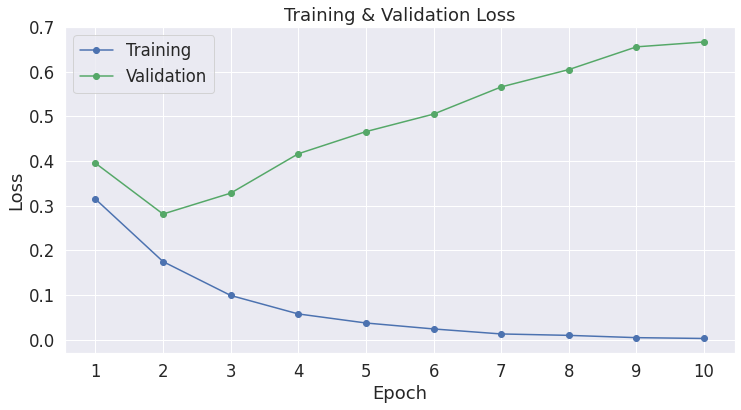

In [36]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.show()

**Results**

After running the model for 10 epochs and with a maximum length for the reviews of 100, there are no good results...

The graph suggest that even with one epoch there are no good reuslts.

For the next implementation I should modify the length to be less, given that the  most cleaned reviews (without short and stop words) are very small (less than 60 words per review).

In [ ]:
# OPTIONS: CHECK MORE THAN 5 - 7
#  either cite a paper or test it


In [ ]:
np.argmax(logits, axis=1).flatten()

In [ ]:
logits = logits[0].detach().cpu().numpy()